In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import math
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt 
from sklearn.linear_model import Lasso

I will be examining the hitters dataset that I obtained from Kaggle. It contains the following features:

* AtBat - Number of times at bat in 1986 

* Hits - Number of hits in 1986

* HmRun - Number of home runs in 1986

* Runs - Number of runs  in 1986

* RBI - Number of runs batted in, in 1986

* Walks - Number of walks in 1986

* Years - Number of years in the MLB

* CAtBat - Number of times at bat during the player's career

* CHits - Number of hits during the player's career

* CHmRun - Number of home runs during the player's career

* CRuns - Number of runs during the player's career

* CRBI - Number of runs batted in duing the player's career

* CWalks - Number of walks during the player's career

* PutOuts - Number of outs during the player's career

* Assists - Number of assists in 1986

* Errors - Number of errors in 1986

* Salary - 1987 salary on opening day in thousands of dollars


The goal is to predict the Salary variable using the other 16 features.

https://www.kaggle.com/mathchi/hitters-baseball-data


In [2]:
## Import the data
file_name = 'Hitters.csv'

try:
    df = pd.read_csv(f'datasets/{file_name}')
    df = df.drop (columns = ['League', 'Division'])
    print(f'{file_name} successfully loaded')

except FileNotFoundError:
    print(f'{file_name} file not found. Please upload to datasets folder')

Hitters.csv successfully loaded


From this, we can tell that there are some missing values in the Salary column, which are likely connected with player that retired after the 1986 season or will not be returning to the MLB for some other reason. I will remove the rows that contain missing values. 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AtBat    322 non-null    int64  
 1   Hits     322 non-null    int64  
 2   HmRun    322 non-null    int64  
 3   Runs     322 non-null    int64  
 4   RBI      322 non-null    int64  
 5   Walks    322 non-null    int64  
 6   Years    322 non-null    int64  
 7   CAtBat   322 non-null    int64  
 8   CHits    322 non-null    int64  
 9   CHmRun   322 non-null    int64  
 10  CRuns    322 non-null    int64  
 11  CRBI     322 non-null    int64  
 12  CWalks   322 non-null    int64  
 13  PutOuts  322 non-null    int64  
 14  Assists  322 non-null    int64  
 15  Errors   322 non-null    int64  
 16  Salary   263 non-null    float64
dtypes: float64(1), int64(16)
memory usage: 42.9 KB


In [4]:
## Drop rows with null values
df = df.dropna()

Here, I am splitting the data into the feature variables and the variable that I will be trying to predict, which is Salary. 

In [5]:
## Split the data into the feature variable (X) and what we are trying to predict (y)
feature_cols = ['AtBat', 'Hits', 'HmRun', 'Runs',
                'RBI', 'Walks', 'Years', 'CAtBat',
                'CHits', 'CHmRun', 'CRuns', 'CRBI',
                'CWalks', 'PutOuts', 'Assists', 'Errors']

X = df[feature_cols]
y = df['Salary']

Here I am using a function from the preprocessing package called scale, which rescales the data as z-scores with mean = 0 and standard deviation = 1. Since the variables are on different scales, this is very useful to do in order to avoid the features with larger values from dominating the model. Additionally, it was very difficult to see the shape of the training vs validation error curves with the unscaled data.

In [6]:
scaled_y = preprocessing.scale(y)
scaled_X = pd.DataFrame(columns=[feature_cols])

for i in range(len(feature_cols)):
    scaled_X[feature_cols[i]] = preprocessing.scale(X[feature_cols[i]])

## Verify the mean and standard deviation of each column 
# print(np.mean(scaled_X[feature_cols])) ## Means
# print(np.std(scaled_X[feature_cols])) ##'Standard Deviations:

Randomly split the scaled data into training and testing sets. The resulting training set has 197 examples, and the resulting test set has 66 examples. It is important to set the random state, I just used 0 in this case, however, it will make the results that I achieve in this assignment reproducable for others. It is essentially equivalent to setting the seed in R. 

In [7]:
## Randomly split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, scaled_y, random_state = 0)

The linear regression has the general form: $y = \Theta_0 + \Theta_1 X_1 + ... + \Theta_n X_n$ where n is the number of features that we are using in the model. In order to obtain the values of the model (using OLS), we have to minimize $J(\Theta) = \sum_{i = 1}^{n} (\Theta^T x_i - y_i)^2$, where i in the number of examples in the data that is being used to train the model. The function is minimized by sklearn using gradient descent, and the algorithm picks the step size $\alpha$ automatically.

Some things to note about this model are:

* The solution obtained may not be a unique solution.
* It is sensitive to outliers.
* It may predict values that are outside the range of values that we have in $y_i$.
* With larger datasets, it might not be possible to store the matrix $X^TX$.
* It assumes a linear relationship between $x_i$ and $y_i$.

The plot titled "Training Error vs Test Error for Linear Regression" from the cell below shows the training error (blue) and test error (orange) on the y axis plotted against the number of parameters that are used in the model on the x axis. We can see that the training error is pretty consistently decreasing as more variables are added to the model. This makes sense, because the more predictors that are added, better the fit becomes with regard to the training set. The test error has a parabola shape from the parameter values 1 to 5, which is what we expect. The behavior is not what would expect for values greater than 5, as there is a very steep drop in the test error starting with n = 6 that I cannot explain, but it would have something to do with the dataset. We see the parabola shape in the test error happen because in models with a small number of parameters, the training data is not learned well, so it cannot be predicted well. On the other hand, with a larger number of parameters, the model learns the training set too well, so it does not generalize well to the test set. We need to pick a number of parameters that does a good job of balancing bias and variance. For this case, from the range of n from 1 to 5, I would pick n = 2 or 3 because those look to be at the bottom of the parabola for the test error which is what we want.

The error is measured by the root mean squared error (RMSE) which is calculated by: $(\frac{1}{n} \sum_{i = 1}^{n} (Y_i - \hat{Y_i})^2 )^{\frac{1}{2}}$ where n in the number of examples in the data. I get the RMSE for both the training set and the test set by fitting the model with X_train and Y_train, then predicting X_train and X_test using the fitted model and then getting the square root of the mean_square_error function output. This is the method that will be used throughout the assignment. 

Note: a model with a low number of parameters is has high bias because it does not learn the data well. On the other hand, a model with too many parameters is high variance because for small changes in the data, there are wildly different predicted values. 

Text(0, 0.5, 'Error (RMSE)')

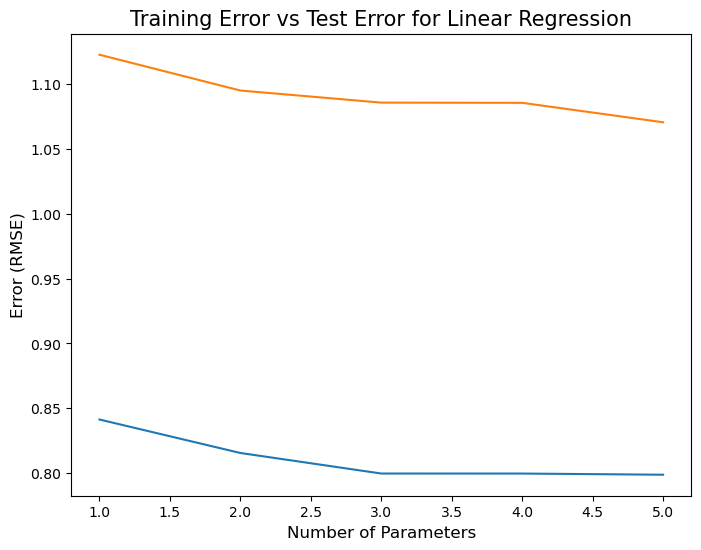

In [8]:
## Regular linear regression
test_error = []
training_error = []
ns = []

for i in range(1,6):
    
    train_X = X_train[feature_cols[0:i]]
    train_y = y_train
    test_X = X_test[feature_cols[0:i]]
    lin_reg = LinearRegression().fit(train_X,train_y)
    
    ns.append(len(train_X.columns))

    ## Training error
    pred_train = lin_reg.predict(train_X)
    MSE_train = mean_squared_error(y_train, pred_train)
    RMSE_train = math.sqrt(MSE_train)
    training_error.append(RMSE_train)

    ## Test Error
    pred_test = lin_reg.predict(test_X)
    MSE_test = mean_squared_error(y_test, pred_test)
    RMSE_test = math.sqrt(MSE_test)
    test_error.append(RMSE_test)


    
plt.figure(figsize = (8,6))
plt.plot(ns, training_error)
plt.plot(ns, test_error)
plt.title("Training Error vs Test Error for Linear Regression", fontsize = 15)
plt.xlabel('Number of Parameters', fontsize = 12)
plt.ylabel('Error (RMSE)', fontsize = 12)


Like the linear regression, the ridge regression also takes on the form:  $y = \Theta_0 + \Theta_1 X_1 + ... + \Theta_n X_n$ where n is the number of features that are used in the model. However, it is different from the linear regression in the way that the $\Theta_j$ values are obtained. In the ridge regression, there is a penalty equivalent to the squared manitude of the coefficients times a value for $\lambda$ of the form $\lambda||\Theta||_2^2$, so we are minimizing the following function: $J(\Theta) = \sum_{i = 1}^{n} (\Theta^T x_i - y_i)^2 + \lambda||\Theta||_2^2$. The consequence of this regularization is that we end up with smaller parameter values ($\Theta$) as $\lambda$ increases because larger values of $\Theta_i$ tend to overfit, and this introduced a penalty for those larger values of $\Theta$. This can be refered to as L2 regularization. When $\lambda = 0$, we get the same $\Theta$ values as we would with the linear regression. Here I fit 40 different models with $\lambda$ values from 0 to 20, increasing by .5 with each iteration. Note that values of $\lambda \geq 0$.


The plot below titled "Training Error vs Test Error Ridge Regression" shows the test error(orange) versus the training error(blue). We see that as the lambda increaes, the test error takes a sharp drop and then looks to have a very slight upward trend for the rest of the curve. On the other hand, the training error rises more steadily and the flattens out as the value of $\lambda$ increases. As the value of lambda is increasing, the distance between the curves for the test error and training error is getting smaller. Based on this chart, I would probably go with a $\lambda$ value of in the neighborhood of 2.5 to 3 because it looks like where the test error is the lowest before it begins to slightly increase. 


From the plot provided, we can see that as the lambda values are increased, the values of the coefficients get smaller and smaller. This makes sense because as lambda is increased the $\lambda||\Theta||_2^2$ part of what is being minimized is being increased, so in order to minimize it, the coefficient values must become smaller. Unlike what we will see in the Lasso regression, which makes use of the L1 norm, we do not see the elimination of parameters. For the range that is shown, the $\Theta$ values are significantly smaller than what they were in the linear regression case, however, the only ones that are really close to zero are the ones that were extremely small to begin with. We should note that as $\lambda \rightarrow \infty$, all $\Theta \rightarrow 0$. 


Text(0, 0.5, 'Parameter Values')

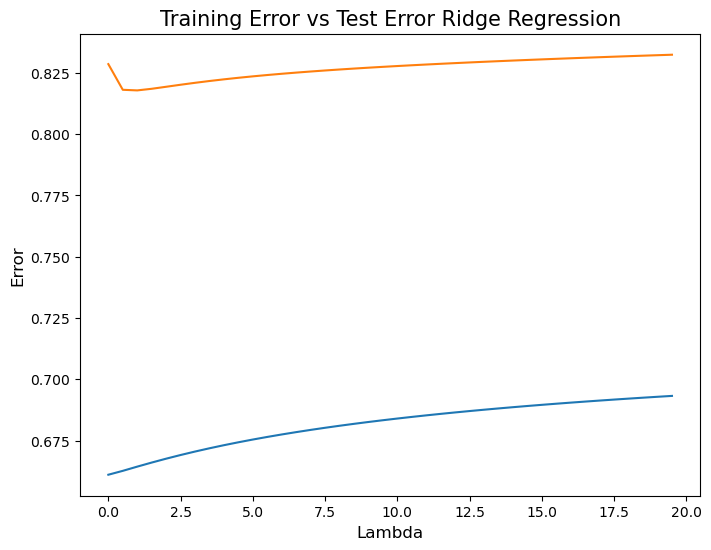

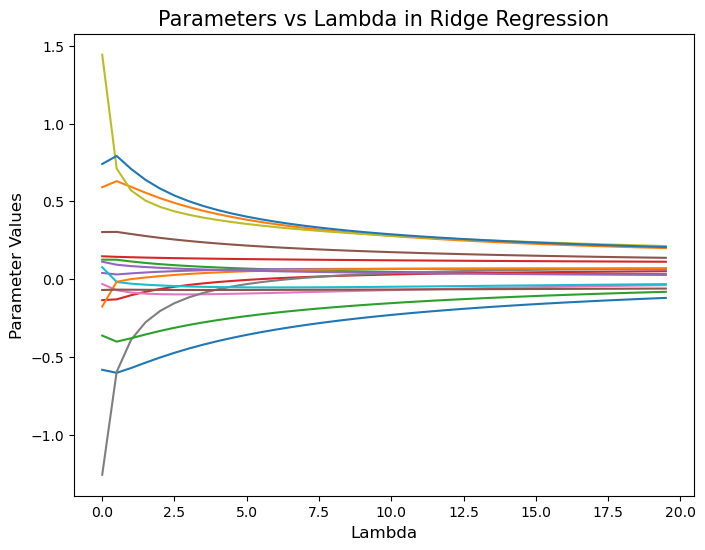

In [9]:
## Ridge Linear Regression
test_error = []
training_error = []
lambdas = np.arange(0,20,.5)
coeffs = pd.DataFrame(columns = ['AtBat', 'Hits', 'HmRun', 'Runs', 
                                 'RBI', 'Walks', 'Years', 'CAtBat',
                                 'CHits', 'CHmRun', 'CRuns', 'CRBI',
                                 'CWalks', 'PutOuts', 'Assists', 'Errors'])


for i in range(len(lambdas)):
    rr = Ridge(alpha = lambdas[i])
    rr.fit(X_train, y_train)
    
    df1 = pd.Series(rr.coef_).to_frame().T
    df1.columns = feature_cols
    
    frames = [coeffs, df1]
    
    coeffs = pd.concat(frames)

    
    ## Training error
    pred_train = rr.predict(X_train)
    MSE_train = mean_squared_error(y_train, pred_train)
    RMSE_train = math.sqrt(MSE_train)
    training_error.append(RMSE_train)

    ## Test Error
    pred_test = rr.predict(X_test)
    MSE_test = mean_squared_error(y_test, pred_test)
    RMSE_test = math.sqrt(MSE_test)
    test_error.append(RMSE_test)



plt.figure(figsize = (8,6))
plt.plot(lambdas, training_error) # Blue
plt.plot(lambdas, test_error) # Orange
plt.title("Training Error vs Test Error Ridge Regression", fontsize = 15)
plt.xlabel('Lambda', fontsize = 12)
plt.ylabel('Error', fontsize = 12)

plt.figure(figsize = (8,6))
plt.plot(lambdas, coeffs[feature_cols])
plt.title("Parameters vs Lambda in Ridge Regression", fontsize = 15)
plt.xlabel('Lambda', fontsize = 12)
plt.ylabel('Parameter Values', fontsize = 12)


Also, like the linear regression and ridge regression, the lasso regression will take on the same from that is:  $y = \Theta_0 + \Theta_1 X_1 + ... + \Theta_n X_n$ with n being the number of features that we are using in the model. However, the Lasso regression is minimizing the following function: $J(\Theta) = \frac{1}{2} ||X\Theta - y||^2 + \lambda||\Theta||_1 $. The penalty term here is equal to the absolute value of the magnitude of the coefficients times a value $\lambda$. This may set some of the coefficients equal to 0, so not only is the L1 norm regularizing the data, but it is also helping us out with feature selection. The output of this algorithm is a sparse matrix of $\Theta$ values, and the larger the value of $\lambda$ the more sparse we would expect the matrix of $\Theta$ values to be. This is because we are minimizing the function $J(\Theta)$ and as $\lambda$ increases, we need to greatly reduce some $\Theta$ values or even eliminate them. Note that values of $\lambda \geq 0$.

Here, I fit 100 different lasso regressions with different lambda to values ranging from 0 to 1 that increase by .01 for each iteration. 

From the plot titled "Error Analysis for Lasso Regression", we can see the training error (blue) and test error (orange) plotted against the value of $\lambda$ on the x-axis. We can see that from $\lambda$ values from 0 to about .01, the curves follow very closely to the pattern that has been described in class where the test error is a parabola, and the training error is increases and then flattens out. We would want to pick a $\lambda$ value that is at the bottom of the valley of the test error, which would probaly be somewhere in the neighborhood of .025. However, as we get past .05, both the training error and test error follow almost the same pattern, where they increase rapidly and the flatten out at a $\lambda$ of just below .6. I believe that this rapid increase in the error is that from the plot of the coefficients, titled "Parameters vs Lambda in Lasso Regression", we can see that is around the point where all of the $\Theta$ values are either 0 or extremely close to 0. 

Speaking more about the plot titled "Parameters vs Lambda in Lasso Regression" we can see that when $\lambda$ is equal to 0, the paramters have the values that they would have in the standard linear regression. However, after lambda starts to increase there are very sharp changes in the $\Theta$ values, and shortly after the value of $\lambda$ becomes non-zero, we begin to see that some of the parameters are getting eliminated, and by $\lambda = .6$ all of the $\Theta$ values are either zero or extremely close to zero.

/Users/Austin/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/Austin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/Austin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.305e+01, tolerance: 1.660e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  

Text(0, 0.5, 'RMSE')

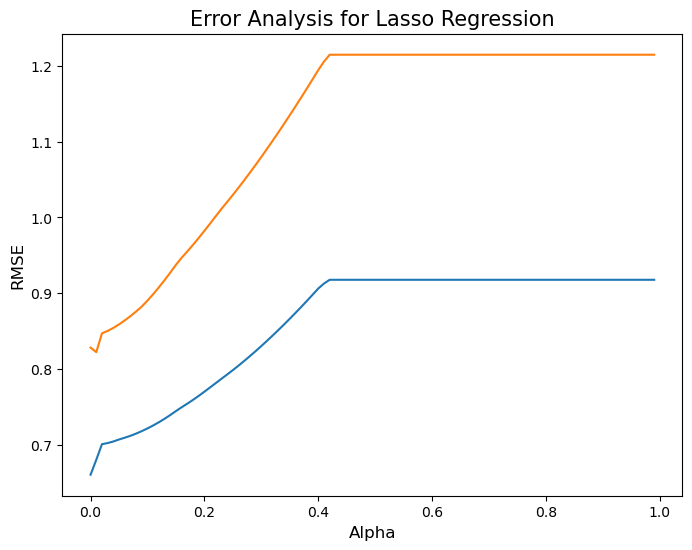

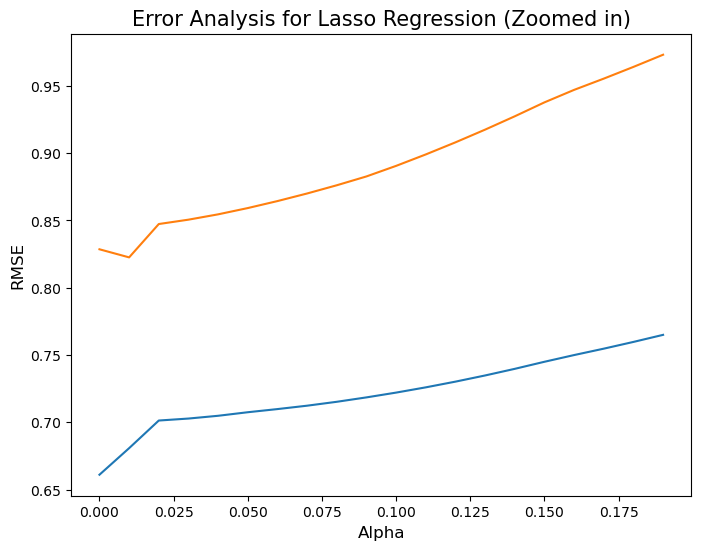

In [10]:
## Lasso Linear Regression
test_error = []
training_error = []
lambdas = np.arange(0,1,.01)
coeffs1 = pd.DataFrame(columns = ['AtBat', 'Hits', 'HmRun', 'Runs', 
                                   'RBI', 'Walks', 'Years', 'CAtBat',
                                   'CHits', 'CHmRun', 'CRuns', 'CRBI',
                                   'CWalks', 'PutOuts', 'Assists', 'Errors'])


for i in range(len(lambdas)):
    lso = Lasso(alpha = lambdas[i])
    lso.fit(X_train, y_train)
    
    df1 = pd.Series(lso.coef_).to_frame().T
    df1.columns = feature_cols
    
    frames = [coeffs1, df1]
    
    coeffs1 = pd.concat(frames)
    
    
    ## Training error
    pred_train = lso.predict(X_train)
    mse_train = mean_squared_error(pred_train, y_train)
    rmse_train = np.sqrt(mse_train)
    training_error.append(rmse_train)
    
    ## Test Error
    pred_test = lso.predict(X_test)
    mse_test = mean_squared_error(pred_test, y_test)
    rmse_test = np.sqrt(mse_test)
    test_error.append(rmse_test)


    
plt.figure(figsize = (8,6))
plt.plot(lambdas, training_error) # blue
plt.plot(lambdas, test_error) # orange 
plt.title('Error Analysis for Lasso Regression', fontsize = 15)
plt.xlabel('Alpha', fontsize = 12)
plt.ylabel('RMSE', fontsize = 12)
##plt.legend(training_error, test_error)

plt.figure(figsize = (8,6))
plt.plot(lambdas[0:20], training_error[0:20]) # blue
plt.plot(lambdas[0:20], test_error[0:20]) # orange 
plt.title('Error Analysis for Lasso Regression (Zoomed in)', fontsize = 15)
plt.xlabel('Alpha', fontsize = 12)
plt.ylabel('RMSE', fontsize = 12)
##plt.legend(training_error, test_error)

Text(0, 0.5, 'Parameter Values')

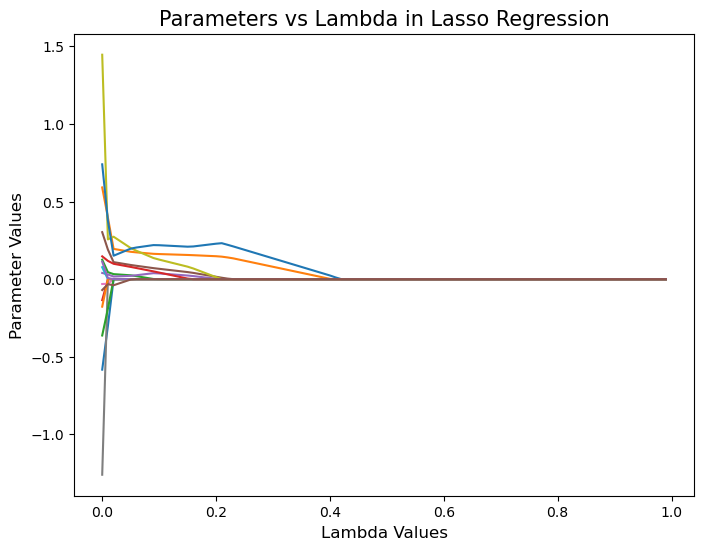

In [11]:
plt.figure(figsize = (8,6))
plt.plot(lambdas, coeffs1[feature_cols])
plt.title("Parameters vs Lambda in Lasso Regression", fontsize = 15)
plt.xlabel('Lambda Values', fontsize = 12)
plt.ylabel('Parameter Values', fontsize = 12)

**Recap**

* All three of the regressions looked at in this assignment take the form: $y = \Theta_0 + \Theta_1 X_1 + ... + \Theta_n X_n$. 
 * Where n is the number of features that we are using in the model.
* Regularization helps to reduce large $\Theta$ values, which helps to reduce overfitting in the model. 
 
 
*Linear Regression (No Regularization)*:
* Minimizing $J(\Theta) = \sum_{i = 1}^{n} (\Theta^T x_i - y_i)^2$ to obtain the coefficient estimates.
    * i is the number of examples in the data being trained.
* The solution obtained may not be a unique solution.
* It is sensitive to outliers.
* It may predict values that are outside the range of values that we have in $y_i$.
* With larger datasets, it might not be possible to store the matrix $X^TX$.
* It assumes a linear relationship between $x_i$ and $y_i$.

*Ridge Regression (L2 Regularization)*:
* Minimizing $J(\Theta) = \sum_{i = 1}^{n} (\Theta^T x_i - y_i)^2 + \lambda||\Theta||_2^2$
    * i is the number of examples in the data being trained.
* The penalty term is equivalent to the squared manitude of the coefficients times a value for $\lambda$.
* When $\lambda = 0$ the coefficients $\Theta$ are equal to the coefficients obtained from the linear regression because the penalty term is not considered when it is multiplied by 0.
* As $\lambda \rightarrow \infty$, all $\Theta \rightarrow 0$. However, this does not set values equal to zero like we will see in the Lasso Regression. The parameters get smaller as $\lambda$ increases.
* Insensitive to changes in the data.
* Advantages:
    * Strictly Convex
    * Differentiable
    * Closed form and unique solution 
    * Decrease variance
* Disadvantage:
    * Uses weights on all features, relying on all features to some degree, which provides a dense solution. We ideally would like to avoid dense solutions.

*Lasso Regression (L1 Regularization)*:
* Minimize $J(\Theta) = \frac{1}{2} ||X\Theta - y||^2 + \lambda||\Theta||_1 $.
* The penalty term here is equal to the absolute value of the magnitude of the coefficients times a value $\lambda$.
* When $\lambda = 0$ the coefficients $\Theta$ are equal to the coefficients obtained from the linear regression because the penalty term is not considered when it is multiplied by 0. The same thing happens in the Ridge Regression. 
* Unlike the Ridge Regression, which is just regularizing, the Lasso Regression is also selecting features for us. It does this by setting parameters to 0. This provides sparsity.
* Insensitive to changes in the data.
* Advantages:
    * Decrease variance
    * Helps us with feature selection by setting parameters to 0 for us. 
* Neutral Point:
    * Convex, but not strictly convex
* Disadvantage:
    * Not differentiable at 0, which is the point where minimization is supposed to bring us to. 
    * Iterative solver, and the solution is not unique